In this notebook, my goal is to show some of the philosophy behind my fajrGPT sound control code. Basically, my goal is to figure out how to tune the sound volume parameters in pygame so that during cross-fades when looping brown noise, the sound pressure level in my room remains roughly constant. The first test I did was just to basically see how the sound volume knobs actually map to sound pressure level, so I took some measurements with my phone and made a script to play brown noise for 5 seconds.

In [15]:
import pygame
import time
import sys; sys.path.append('../')
import matplotlib.pyplot as plt
import numpy as np

Code to obtain experimental data

In [8]:
volume_test = 1

In [9]:
# define the mp3 path
mp3_path = "../fajrGPT/assets/brown.mp3"

# Initialize Pygame mixer
pygame.mixer.init()

# load the audio into a channel
audio = pygame.mixer.Sound(mp3_path)
channel = pygame.mixer.Channel(1)

# set the volume of channel 1 to 1
channel.set_volume(volume_test)

# play the audio
channel.play(audio, loops=0)

# stop the audio after 5 seconds
time.sleep(5)

# stop the audio
channel.stop()

Data plotting

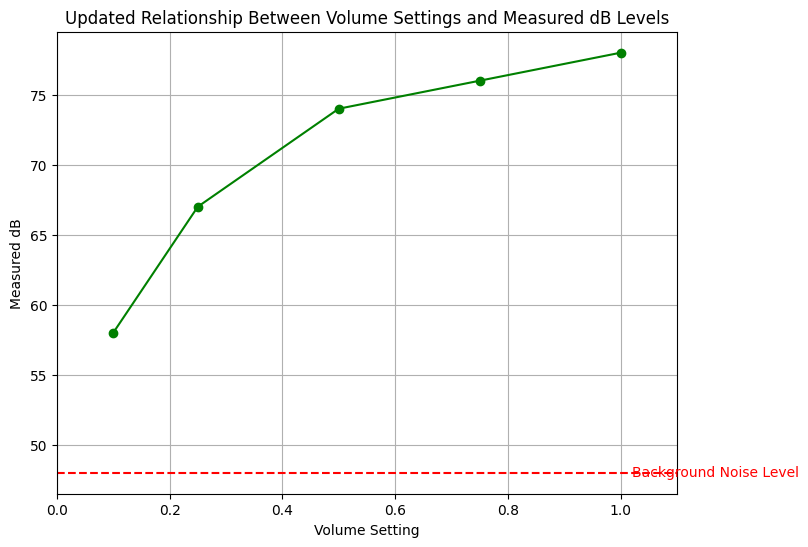

In [11]:
# Updated data: volume settings and corresponding measured dB levels
volume_settings_updated = [1.0, 0.75, 0.5, 0.25, 0.1]
measured_dB_updated = [78, 76, 74, 67, 58]

# Creating the plot with updated data
plt.figure(figsize=(8, 6))
plt.plot(volume_settings_updated, measured_dB_updated, marker='o', color='green')

# Adding labels and title
plt.xlabel('Volume Setting')
plt.ylabel('Measured dB')
plt.title('Updated Relationship Between Volume Settings and Measured dB Levels')

# Indicating the background noise level
background_noise_level = 48
plt.axhline(y=background_noise_level, color='r', linestyle='--')
plt.text(1.02, background_noise_level, 'Background Noise Level', verticalalignment='center', color='red')
plt.xlim(0, 1.1)

# Show grid
plt.grid(True)

# Display the plot
plt.show()

My next question was what equation could I use to map from volume setting to dB? It looks to be some logarithmic based model, but I am going to try and fit it with polyfit.

In [23]:
x_values = np.linspace(0, 1, 100)

/var/folders/1h/qfss5lwn3jzdb7t8r1y63r9r0000gn/T/ipykernel_86633/3533385264.py:5: RuntimeWarning: invalid value encountered in log10
  return a * np.log10(b * x + c)


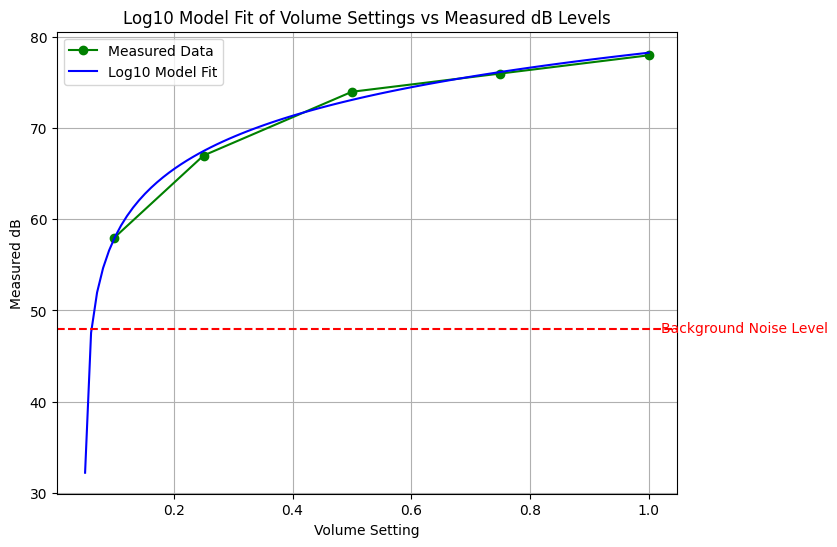

In [27]:
from scipy.optimize import curve_fit

# Defining the log10 model function
def log10_model(x, a, b, c):
    return a * np.log10(b * x + c)

# Fitting the log10 model to the data
params, covariance = curve_fit(log10_model, volume_settings_updated, measured_dB_updated)

# Generating y values for plotting the log10 model fit
y_values_log10 = log10_model(x_values, *params)

# Creating the plot with log10 model fit
plt.figure(figsize=(8, 6))
plt.plot(volume_settings_updated, measured_dB_updated, marker='o', color='green', label='Measured Data')
plt.plot(x_values, y_values_log10, color='blue', label='Log10 Model Fit')

# Adding labels, legend, and title
plt.xlabel('Volume Setting')
plt.ylabel('Measured dB')
plt.title('Log10 Model Fit of Volume Settings vs Measured dB Levels')
plt.legend()

# Indicating the background noise level
plt.axhline(y=background_noise_level, color='r', linestyle='--')
plt.text(1.02, background_noise_level, 'Background Noise Level', verticalalignment='center', color='red')

# Show grid
plt.grid(True)

# Display the plot
plt.show()

# Output the log10 model equation
log10_model_equation = f'Log10 Model Equation: y = {params[0]:.2f} * log10({params[1]:.2f} * x + {params[2]:.2f})'

In [28]:
print(log10_model_equation)

Log10 Model Equation: y = 15.98 * log10(83460.60 * x + -4111.76)


We can see that a logarithmic fit does a pretty good job of approximating our data. Now we had the following thought:

/var/folders/1h/qfss5lwn3jzdb7t8r1y63r9r0000gn/T/ipykernel_86633/3533385264.py:5: RuntimeWarning: invalid value encountered in log10
  return a * np.log10(b * x + c)


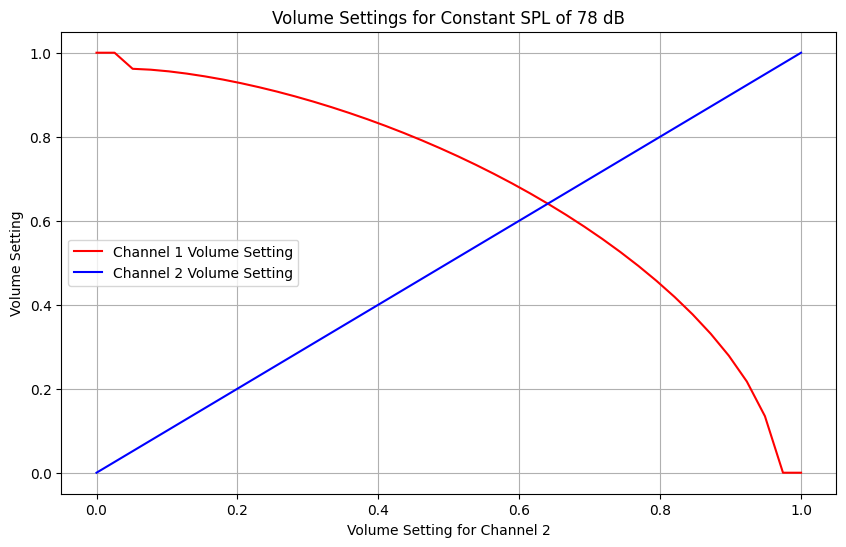

In [47]:
def find_volume_setting_for_constant_SPL(target_SPL, channel_2_volume, model_params, initial_guess=0):
    """
    Find the volume setting for Channel 1 to maintain a constant SPL,
    given the volume setting of Channel 2.
    """
    def SPL_difference(channel_1_volume):
        # SPL for Channel 1
        SPL_ch1 = log10_model(channel_1_volume, *model_params)
        # SPL for Channel 2
        SPL_ch2 = log10_model(channel_2_volume, *model_params)
        # Combined SPL, considering the 3 dB increase for two sources
        combined_SPL = 10 * np.log10(10**(SPL_ch1/10) + 10**(SPL_ch2/10))
        # Difference from target SPL
        return abs(combined_SPL - target_SPL)

    # Finding the volume setting for Channel 1
    from scipy.optimize import minimize_scalar
    result = minimize_scalar(SPL_difference, bounds=(0, 1), method='bounded', options={'xatol': 1e-4})
    return result.x if result.success else initial_guess

# Testing the function over a range of volume settings for Channel 2
channel_2_volumes = np.linspace(0, 1, 40)
channel_1_volumes = np.array([find_volume_setting_for_constant_SPL(78, v, params) for v in channel_2_volumes])

# set the first sequence of zero values in channel 1 to be the first non-zero value
for i in range(len(channel_1_volumes)):
    if channel_1_volumes[i] != 0:
        channel_1_volumes[:i] = 1
        break

# Plotting the volume settings for both channels
plt.figure(figsize=(10, 6))
plt.plot(channel_2_volumes, channel_1_volumes, label='Channel 1 Volume Setting', color='red')
plt.plot(channel_2_volumes, channel_2_volumes, label='Channel 2 Volume Setting', color='blue')
plt.xlabel('Volume Setting for Channel 2')
plt.ylabel('Volume Setting')
plt.title('Volume Settings for Constant SPL of 78 dB')
plt.legend()
plt.grid(True)
plt.show()


In [48]:
# find a model that fits the channel 1 data
fit = np.polyfit(channel_2_volumes, channel_1_volumes, 2)

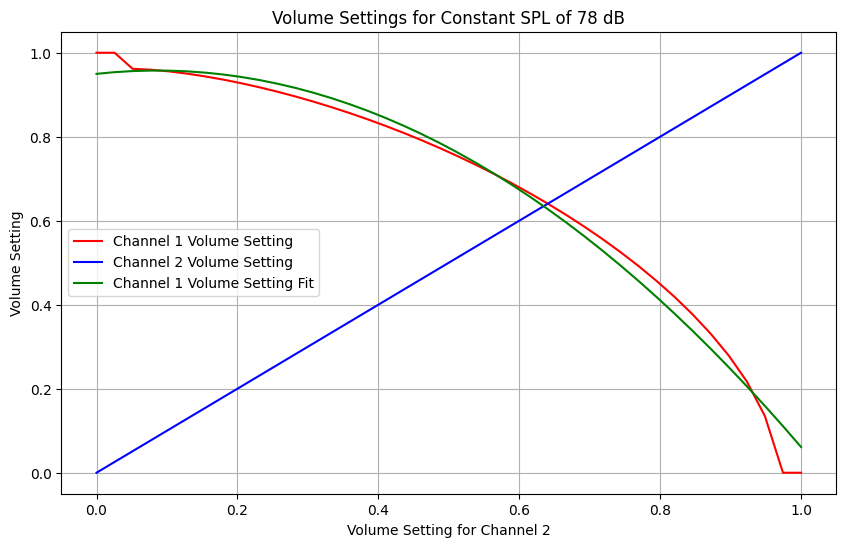

In [49]:
# use the fit parameters to produce a updated plot
plt.figure(figsize=(10, 6))
plt.plot(channel_2_volumes, channel_1_volumes, label='Channel 1 Volume Setting', color='red')
plt.plot(channel_2_volumes, channel_2_volumes, label='Channel 2 Volume Setting', color='blue')
plt.plot(channel_2_volumes, np.polyval(fit, channel_2_volumes), label='Channel 1 Volume Setting Fit', color='green')
plt.xlabel('Volume Setting for Channel 2')
plt.ylabel('Volume Setting')
plt.title('Volume Settings for Constant SPL of 78 dB')
plt.legend()
plt.grid(True)
plt.show()

In [50]:
# the fit parameters are the coefficients of the polynomial: a*x^2 + b*x + c
print(fit)

[-1.07283614  0.184423    0.94967516]


Hence from this analysis, we found a sufficient model for our channel 1 volume as a function of the linearly increasing channel 2 volume: 

$$ x_{1} = -1.073 x_{2}^2 + 0.18x_2 + 0.95$$